In [1]:
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")
from model_operators import *
from utils import *
from code_generation import *
from graph_grammar import *
from models_and_guides import *
from inference import *

In [2]:
%load_ext autoreload

%autoreload 2

In [44]:
factor = nx.DiGraph()

In [45]:
nodes = [
    #('z_loc',{'type':'const', 'value':0.}),
    #('z_scale',{'type':'const', 'value':1.}),
    ('z_loc',{'type':'function', 'function':torch.zeros, 'args':(Name(id='K'),)}),
    ('z_scale',{'type':'function', 'function':torch.ones, 'args':(Name(id='K'),)}),
    ('z',{'distribution':dist.Normal,'type':'latent','event_dims':1}),
    #('z_T',{'type':'deterministic', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    #('z_T',{'type':'function', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    ('cov_diag_loc',{'type':'param','shape':'D'}),
    ('cov_diag_scale',{'type':'param','shape':'D','constraint':'positive'}),
#    ('cov_factor_loc',{'type':'param','shape':'KD'}),
#    ('cov_factor_scale',{'type':'param','shape':'KD','constraint':'positive'}),
    ('cov_factor_loc',{'type':'param','shape':'DK'}),
    ('cov_factor_scale',{'type':'param','shape':'DK','constraint':'positive'}),
    ('cov_factor',{'distribution':dist.Normal,'type':'latent','event_dims':2}),
    #('Wz',{'type':'deterministic', 'function':torch.matmul}),
    ('Wz',{'type':'function', 'function':torch.matmul, 'args':('p','t')}),
    ('X',{'distribution':dist.MultivariateNormal,'type':'obs'}),
    ('cov_diag',{'distribution':dist.LogNormal,'type':'latent','event_dims':1}),
    ('cov_diag_j',{'type':'function', 'function':torch.add, 'args':('p',Num(n=0.0001))}),
    #('diag',{'type':'deterministic', 'function':torch.diag_embed}),
    ('diag',{'type':'function', 'function':torch.diag_embed}),
]

In [46]:
edges = [
    ('cov_diag_loc','cov_diag',{'type':'param','param':'loc'}),
    ('cov_diag_scale','cov_diag',{'type':'param','param':'scale'}),
    ('cov_factor_loc','cov_factor',{'type':'param','param':'loc'}),
    ('cov_factor_scale','cov_factor',{'type':'param','param':'scale'}),
    ('z_loc','z',{'type':'param','param':'loc'}),
    ('z_scale','z',{'type':'param','param':'scale'}),    
    #('z','Wz',{'type':'arg', 'transpose':True}),
#    ('z','z_T',{'type':'arg'}),
#    ('z_T','Wz',{'type':'arg'}),
    ('z','Wz',{'type':'arg'}),
    ('cov_factor','Wz',{'type':'arg'}),
    ('Wz','X',{'type':'param','param':'loc'}),
    #('cov_diag','X',{'type':'param','param':'scale'})
    ('cov_diag','cov_diag_j',{'type':'arg'}),
    ('cov_diag_j','diag',{'type':'arg'}),
    ('diag','X',{'type':'param','param':'covariance_matrix'})
]

In [47]:
plate_attr = {
#    'cov_factor':{'plates':['D','K']},
#    'cov_diag':{'plates':['D']},
    'X':{'plates':['N']},
    'Wz':{'plates':['N']},
    #'z':{'plates':['N','K']},
    'z':{'plates':['N']},
    #'z_T':{'plates':['N']}
}

In [48]:
factor.add_nodes_from(nodes)
factor.add_edges_from(edges)
nx.set_node_attributes(factor, plate_attr)

W: D, K

z: K, N

Sigma: D

Wz: N

X: N

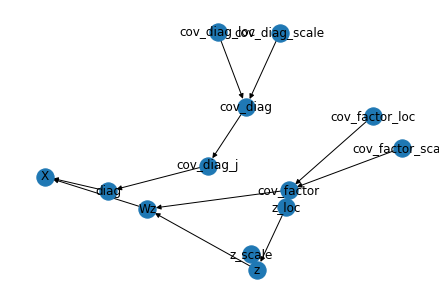

In [49]:
nx.draw(factor, with_labels=True)

In [50]:
marg_factor = marginalize_factor(factor)

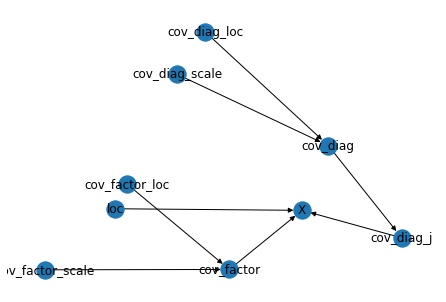

In [51]:
nx.draw(marg_factor, with_labels=True)

In [100]:
mixture = mixture_from_marg_factor(marg_factor)

In [101]:
nx.draw(mixture, with_labels=True)

/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


In [102]:
nx.get_node_attributes(mixture, 'plates')

{'cov_diag_loc': ['C'],
 'cov_diag_scale': ['C'],
 'cov_factor_loc': ['C'],
 'cov_factor_scale': ['C'],
 'cov_factor': ['C'],
 'X': ['N'],
 'cov_diag': ['C'],
 'cov_diag_j': ['C'],
 'loc': ['C'],
 'assignment': ['N'],
 'cov_factor_idx': ['N'],
 'cov_diag_j_idx': ['N'],
 'loc_idx': ['N']}

In [103]:
nx.get_node_attributes(mixture, 'shape')

{'cov_diag_loc': 'CD',
 'cov_diag_scale': 'CD',
 'cov_factor_loc': 'CDK',
 'cov_factor_scale': 'CDK',
 'mixing_proportions_concentration': 'C',
 'loc_loc': 'CD',
 'loc_scale': 'CD'}

In [104]:
#generate_Model_class(marg_factor)
generate_Model_class(mixture)

In [105]:
from model import DAGModel

In [106]:
pyro.clear_param_store()
N = 1000
D = 2
K = 4
C = 5
dagmodel = DAGModel(torch.zeros(N,D),K,C,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

In [107]:
dagmodel.param_shapes_and_support

{'loc_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'loc_prior_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'loc_loc_init_id': ((5, 2), Real()),
 'loc_prior_loc_init_id': ((5, 2), Real()),
 'mixing_proportions_concentration_init_id': ((5,),
  GreaterThan(lower_bound=0.0)),
 'mixing_proportions_prior_concentration_init_id': ((5,),
  GreaterThan(lower_bound=0.0)),
 'cov_factor_scale_init_id': ((5, 2, 4), GreaterThan(lower_bound=0.0)),
 'cov_factor_prior_scale_init_id': ((5, 2, 4), GreaterThan(lower_bound=0.0)),
 'cov_factor_loc_init_id': ((5, 2, 4), Real()),
 'cov_factor_prior_loc_init_id': ((5, 2, 4), Real()),
 'cov_diag_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'cov_diag_prior_scale_init_id': ((5, 2), GreaterThan(lower_bound=0.0)),
 'cov_diag_loc_init_id': ((5, 2), Real()),
 'cov_diag_prior_loc_init_id': ((5, 2), Real())}

In [108]:
dgp = dagmodel.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])

new_dgp = pyro.poutine.condition(dgp, data={'loc_id':true_variables['loc_id']*20})
trace = pyro.poutine.trace(new_dgp).get_trace(torch.empty(N,D))

true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()
Xz = torch.cat([X,true_variables['assignment_id'].detach().float().unsqueeze(-1)],dim=-1)
Xzdata, Xztest_data = train_test_split(Xz)
data, train_assign = Xzdata[:,:-1],Xzdata[:,-1]
test_data, test_assign = Xztest_data[:,:-1],Xztest_data[:,-1]

In [109]:
X.shape

torch.Size([1000, 2])

In [110]:
rand_idx = np.random.choice(D,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
#plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [111]:
config = dict(
        n_iter = 8000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [112]:
pyro.clear_param_store()
N = 1000
D = 2
K = 4
C = 2
student = DAGModel(torch.zeros(N,D),K,C,N,'id')

In [113]:
telemetry = inference(student, data, test_data, config=config)



NLL after 0/8000 iterations is 17.41405487060547
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

NLL after 7500/8000 iterations is 8.594182014465332


.............................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [115]:
config['telemetry'] = telemetry
config['n_iter'] = 2000

In [116]:
telemetry2 = inference(student, data, test_data, config=config)

Continuing from previous inference run.


NLL after 8000/14000 iterations is 8.572063446044922


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

NLL after 8500/14000 iterations is 8.56112003326416


............................................................................................................................................................................................................................................................................................................................................................

In [117]:
student.sample_posterior_predictive(data.shape[0])

In [118]:
foo = student.posterior_predictive(data)

In [89]:
plt.plot(telemetry['loss'])

In [119]:
plt.plot(telemetry['MNLL'])

In [120]:
foo['obs'].shape

torch.Size([900, 1, 2])

In [121]:
foo['assignment_id'].shape

torch.Size([900, 1])

In [122]:
%matplotlib qt
#plt.scatter(*data[:,rand_idx].T)
plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

In [123]:
plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,0].squeeze().T.detach())

In [124]:
foo['mixing_proportions_id']

tensor([[[1.0000e+00, 5.7492e-14]],

        [[1.0000e+00, 1.1755e-38]],

        [[1.0000e+00, 1.1755e-38]],

        ...,

        [[1.0000e+00, 4.3479e-18]],

        [[9.9986e-01, 1.3891e-04]],

        [[1.0000e+00, 1.1755e-38]]], grad_fn=<ViewBackward>)

In [94]:
def compute_assignments(data, posterior_samples):
    n_posterior_samples,C,D = posterior_samples['loc_id'].shape

    n_posterior_samples = 200
    # get component distributions
    components = dist.LowRankMultivariateNormal(posterior_samples['loc_id'][:n_posterior_samples],posterior_samples['cov_factor_id'][:n_posterior_samples],posterior_samples['cov_diag_id'][:n_posterior_samples])

    # find log_prob of every datapoint under each component, for all posterior samples
    responsibilities = components.log_prob(data.unsqueeze(-2).unsqueeze(-2))

    greatest_responsibility,most_responsible = responsibilities.max(dim=-1)

    return most_responsible.sum(1)>n_posterior_samples/C

In [96]:
%matplotlib qt
#plt.scatter(*data[:,rand_idx].T,c=compute_assignments(data, foo))
#plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach(),alpha=.1)

In [ ]:
# select component (pi,mu,W,Sigma) = (mixing_proportions, loc, cov_factor, cov_diag) for splitting
# define two new components (pi_1,mu_1,W_1,Sigma_1) and (pi_2,mu_2,W_2,Sigma_2), such that
# pi_1 = pi_2 P pi/2
# mu_1, mu_2 = mu +- w, where w is the sum of eigenvectors of cov_factor.cov_factor.T + cov_diag**2, weighted by eigenvalues
# the others are simply copied over

In [ ]:
teacher = student
# create a new model for each component, with that component split along first principal component
for c in range(teacher.C):
    pyro.clear_param_store()
    N = teacher.N
    D = teacher.D
    K = teacher.K
    C = teacher.C + 1
    new_student = DAGModel(torch.zeros(N,D),K,C,N,'id_'+str(c))
    
    component_cov_mat = torch.matmul(teacher.params['cov_factor_loc_id'][c],teacher.params['cov_factor_loc_id'][c].T) + torch.diag(teacher.params['cov_diag_loc_id'][c]**2)
    eigvals, eigvecs = torch.eig(component_cov_mat, eigenvectors=True)
    #new_component_loc_displacement = torch.matmul(torch.sqrt(eigvals[:,0]),eigvecs.T)
    lamda,idx = eigvals[:,0].max(0)
    pc = lamda*eigvecs[idx]
    
    print(pc)
    #
    plt.figure()
    ax = plt.axes()
    plt.scatter(*foo['obs'][:,1,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,1].squeeze().T.detach())

    ax.arrow(*teacher.params['loc_loc_id'][c], *(teacher.params['loc_loc_id'][c]+pc), head_width=0.5, head_length=0.7, fc='lightblue', ec='black')
    plt.axis('equal')

In [ ]:
component_cov_mat

In [ ]:
pc

In [ ]:
    
    # create param init for new_student model
    for param_name, param_value in new_student.param_init.items():
        teacher_param_name = param_name.replace('init_'+new_student._id, teacher._id)
        for component,_ in enumerate(teacher.params[teacher_param_name]):
            if component == c:
                # split locs in two
                if param_name in ['loc_loc_init_id', 'loc_prior_loc_init_id']:
                    comp1 = teacher.params[teacher_param_name][component] + pc
                    comp2 = teacher.params[teacher_param_name][component] - pc
                # split mixing proportions in two
                elif param_name in ['mixing_proportions_concentration_init_id', 'mixing_proportions_prior_concentration_init_id']:
                    comp1 = comp2 = teacher.params[teacher_param_name][component]/2
                else:
                    comp1 = comp2 = teacher.params[teacher_param_name][component]
                new_student.param_init[param_name][component] = comp1
                new_student.param_init[param_name][component + 1] = comp2
                next
            else:
                new_student.param_init[param_name][component] = teacher.params[teacher_param_name][component]
                
    # train one iteration
    one_iter_config = config.copy()
    one_iter_config['n_iter'] = 1
    telemetry = inference(new_student, data, test_data, config=one_iter_config)
    
    # get posterior sample
    new_student.sample_posterior_predictive(N)
    ppc = new_student.posterior_predictive(data)

    # plot
    plt.figure()
    plt.scatter(*ppc['obs'][:,0,rand_idx].squeeze().T.detach(),c=ppc['assignment_'+new_student._id][:,0].squeeze().T.detach(), alpha=.1)

In [ ]:
pyro.clear_param_store()
N = 1000
D = 2
K = 4
C = 3
new_student = DAGModel(torch.zeros(N,D),K,C,N,'id')

In [ ]:
new_student.param_init

In [ ]:
new_student.param_init['loc_prior_scale_init_id']

In [ ]:
student.params['loc_prior_scale_id']

In [ ]:
old_student = student

In [ ]:
teacher = old_student
student = new_student
param_name = 'loc_loc_init_id'
teacher_param_name = param_name.replace('init_'+student._id, teacher._id)

In [ ]:
teacher_param_name

In [ ]:
c = 1

local_cov_mat = torch.matmul(teacher.params['cov_factor_loc_id'][c],teacher.params['cov_factor_loc_id'][c].T) + torch.diag(teacher.params['cov_diag_loc_id'][c]**2)
eigvals, eigvecs = torch.eig(local_cov_mat, eigenvectors=True)
new_component_loc_displacement = torch.matmul(torch.sqrt(eigvals[:,0]),eigvecs.T)

ax = plt.axes()
plt.scatter(*foo['obs'][:,1,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,1].squeeze().T.detach())

ax.arrow(*teacher.params['loc_loc_id'][c], *new_component_loc_displacement, head_width=0.5, head_length=0.7, fc='lightblue', ec='black')
#ax.arrow(*student.params['loc_loc_id'][c], *-vec, head_width=0.5, head_length=0.7, fc='lightblue', ec='black')

#plt.xlim(-20,40)
#plt.ylim(-80,10)
#plt.grid()

In [ ]:
for param_name, param_value in student.param_init.items():
    teacher_param_name = param_name.replace('init_'+student._id, teacher._id)
    for component,_ in enumerate(teacher.param_init[param_name]):
        if component == c:
            if param_name in ['loc_loc_init_id', 'loc_prior_loc_init_id']:
                comp1 = teacher.params[teacher_param_name][component] + new_component_loc_displacement
                comp2 = teacher.params[teacher_param_name][component] - new_component_loc_displacement
            elif param_name in ['mixing_proportions_concentration_init_id', 'mixing_proportions_prior_concentration_init_id']:
                comp1 = comp2 = teacher.params[teacher_param_name][component]/2
            else:
                comp1 = comp2 = teacher.params[teacher_param_name][component]
            student.param_init[param_name][component] = comp1
            student.param_init[param_name][component + 1] = comp2
            next
        else:
            student.param_init[param_name][component] = teacher.params[teacher_param_name][component]

In [ ]:
student.param_init[param_name].shape

In [ ]:
teacher.params[teacher_param_name].shape

In [ ]:
config = dict(
        n_iter = 1,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [ ]:
telemetry = inference(student, data, test_data, config=config)

In [ ]:
student.sample_posterior_predictive(N)

In [ ]:
foo = student.posterior_predictive(data)

foo['obs'].shape

In [ ]:
#plt.scatter(*data[:,rand_idx].T)
#plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach())

#plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,0].squeeze().T.detach())

In [ ]:
config = dict(
        n_iter = 4000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [ ]:
telemetry = inference(student, data, test_data, config=config)

In [ ]:
student.sample_posterior_predictive(N)

foo = student.posterior_predictive(data)

#plt.scatter(*data[:,rand_idx].T)
#plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach())

#plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,0].squeeze().T.detach())

In [ ]:
old_student = student
teacher = student

In [ ]:
c = 1

local_cov_mat = torch.matmul(teacher.params['cov_factor_loc_id'][c],teacher.params['cov_factor_loc_id'][c].T) + torch.diag(teacher.params['cov_diag_loc_id'][c]**2)
eigvals, eigvecs = torch.eig(local_cov_mat, eigenvectors=True)
new_component_loc_displacement = torch.matmul(torch.sqrt(eigvals[:,0]),eigvecs.T)

ax = plt.axes()
plt.scatter(*foo['obs'][:,1,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,1].squeeze().T.detach())

ax.arrow(*teacher.params['loc_loc_id'][c], *new_component_loc_displacement, head_width=0.5, head_length=0.7, fc='lightblue', ec='black')
#ax.arrow(*student.params['loc_loc_id'][c], *-vec, head_width=0.5, head_length=0.7, fc='lightblue', ec='black')

#plt.xlim(-20,40)
#plt.ylim(-80,10)
#plt.grid()

In [ ]:
for param_name, param_value in student.param_init.items():
    teacher_param_name = param_name.replace('init_'+student._id, teacher._id)
    for component,_ in enumerate(teacher.param_init[param_name]):
        if component == c:
            if param_name in ['loc_loc_init_id', 'loc_prior_loc_init_id']:
                comp1 = teacher.params[teacher_param_name][component] + new_component_loc_displacement
                comp2 = teacher.params[teacher_param_name][component] - new_component_loc_displacement
            elif param_name in ['mixing_proportions_concentration_init_id', 'mixing_proportions_prior_concentration_init_id']:
                comp1 = comp2 = teacher.params[teacher_param_name][component]/2
            else:
                comp1 = comp2 = teacher.params[teacher_param_name][component]
            student.param_init[param_name][component] = comp1
            student.param_init[param_name][component + 1] = comp2
            next
        else:
            student.param_init[param_name][component] = teacher.params[teacher_param_name][component]

In [ ]:
config = dict(
        n_iter = 1,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [ ]:
telemetry = inference(student, data, test_data, config=config)

In [ ]:
student.sample_posterior_predictive(N)

foo = student.posterior_predictive(data)

#plt.scatter(*data[:,rand_idx].T)
#plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach())

#plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,0].squeeze().T.detach())

In [ ]:
def incremental_init(student, teacher):
    # modify parameters of student model to those of the teacher model
    # assuming student has been randomly initialized
    # assuming both student and teacher have the same parameter names, modulo id
    # assuming teacher has smaller- or equal-sized parameters
    for param_name, param_value in student.param_init.items():
        teacher_param_name = param_name.replace('init_'+student._id, teacher._id)
        assert teacher_param_name in teacher.params.keys()
        # if corresponding param has same shape, use it
        if param_value.shape == teacher.params[teacher_param_name].shape:
            student.param_init[param_name] = teacher.params[teacher_param_name]
        # if corresponding param has fewer rows, replace those
        elif param_value.shape[0] > teacher.params[teacher_param_name].shape[0]:
            student.param_init[param_name][:teacher.params[teacher_param_name].shape[0]] = teacher.params[teacher_param_name]
        else:
            print(f"Parameter {param_name} and {teacher_param_name} have incompatible shapes.")

In [ ]:
foo.keys()

In [ ]:
foo['loc_id'].shape

In [ ]:
foo['loc_id'][0,0]

In [ ]:
foo['cov_factor_id'][0,0]

In [ ]:
foo['cov_diag_id'][0,0]

In [ ]:
entropies = []
entropies2 = []
for i in range(1000):
    et = dist.LowRankMultivariateNormal(foo['loc_id'][i,0],foo['cov_factor_id'][i,0],foo['cov_diag_id'][i,0])
    entropies.append(et.entropy())
    to = dist.LowRankMultivariateNormal(foo['loc_id'][i,1],foo['cov_factor_id'][i,1],foo['cov_diag_id'][i,1])
    entropies2.append(to.entropy())

In [ ]:
plt.hist(torch.tensor(entropies),'auto')
plt.figure()
plt.hist(torch.tensor(entropies2),'auto')

In [ ]:
plt.scatter(*data[train_assign==1][:,rand_idx].T)

In [ ]:
data[train_assign==1].shape